In [1]:
import json
import pandas as pd
import numpy as np
import torch
import string
import nltk
import emoji
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from nltk.stem import WordNetLemmatizer
from contractions import fix
from nltk.tokenize import word_tokenize
from nltk import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import swifter

In [2]:
data = []
with open('tweet/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line)) 
f.close()

emotion = pd.read_csv('tweet/emotion.csv')
data_identification = pd.read_csv('tweet/data_identification.csv')

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

train_data = train_data.merge(emotion, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

train_data_sample = train_data.sample(frac=0.5, random_state=42)
train_data_sample.to_pickle("train_dsample.pkl")
train_df = pd.read_pickle("train_dsample.pkl")

test_data.to_pickle("test_d.pkl")
test_df = pd.read_pickle("test_d.pkl")

In [3]:
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk import wordnet


# stop_words = set(stopwords.words('english'))

# 表情符號替換詞典
emoji_dict = {
    '😂': '[joy]', '❤️': '[love]', '😍': '[adoration]', '😭': '[cry]',
    '❤': '[care]', '😊': '[happy]', '🙏': '[pray]', '😘': '[kiss]',
    '💕': '[love_each_other]', '🔥': '[fire]', '😩': '[weary]',
    '🤔': '[think]', '💯': '[perfect]', '💙': '[loyalty]',
    '🙄': '[annoyed]', '😁': '[happy]', '🙌': '[celebrate]',
    '🙏🏾': '[pray]', '👍': '[approve]', '🙏🏽': '[pray]'
}

# Define a dictionary for common Twitter abbreviations/slangs
slang_dict = {
    "lol": "laugh out_loud",
    "u": "you",
    "idk": "I do not know",
    "omg": "oh my god",
    "btw": "by the way",
    "lmao": "laugh my_ass_off",
    "lmfao": "laugh my_ass_off",
    "fyi": "for your information",
    "brb": "be right back"
    # Add more as needed
}

# 預處理函數
def preprocess_text(text):
    # 替換 emoji
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    text = emoji.replace_emoji(text, replace='')  # 移除其他 emoji
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # 移除網址
    text = re.sub(r'RT[\s]+', '', text)  # Remove RT
    text = text.replace('<LH>', '')
    text = re.sub(r'\@\w+|\#', '', text)  # 移除 @user 和 hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # 移除特殊字元
    text = text.lower()
    text = re.sub(r'[^\w\s!?]', '', text)
    text = re.sub(r'not\s+(\w+)', r'not_\1', text)
    
    wds = text.split()
    tweet = " ".join([slang_dict[wd.lower()] if wd.lower() in slang_dict else wd for wd in wds])
    
    text = fix(text)
    #text = str(TextBlob(text).correct())

    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(wd) for wd in text.split()])
    
    text = text.strip()
    
    
    words = word_tokenize(text)
    return ' '.join([word for word in words])

# 清理訓練與測試資料
train_df['clean_text'] = train_df['text'].swifter.apply(preprocess_text)
test_df['clean_text'] = test_df['text'].swifter.apply(preprocess_text)

# 打亂訓練資料
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

Pandas Apply:   0%|          | 0/724591 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/411972 [00:00<?, ?it/s]

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=20000, oov_token='<UNK>')

tokenizer.fit_on_texts(train_df['clean_text'])

print(tokenizer.texts_to_sequences([train_df['clean_text'][10]]))

[[1, 25, 12, 941, 13249, 125]]


In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

padded_train_sequences = get_sequences(tokenizer, train_df['clean_text'])

In [6]:
padded_train_sequences

array([[18022,   566,     7, ...,     0,     0,     0],
       [   47,     4,    25, ...,     0,     0,     0],
       [  229,  3459,     4, ...,     0,     0,     0],
       ...,
       [  133,   291,   288, ...,     0,     0,     0],
       [   26,   291,    31, ...,     0,     0,     0],
       [   83,    12,    63, ...,     0,     0,     0]])

In [7]:
classes = set(train_df['emotion'])
print(classes)


{'joy', 'surprise', 'fear', 'trust', 'disgust', 'anger', 'anticipation', 'sadness'}


In [8]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
print(classes_to_index)
print(index_to_classes)

{'joy': 0, 'surprise': 1, 'fear': 2, 'trust': 3, 'disgust': 4, 'anger': 5, 'anticipation': 6, 'sadness': 7}
{0: 'joy', 1: 'surprise', 2: 'fear', 3: 'trust', 4: 'disgust', 5: 'anger', 6: 'anticipation', 7: 'sadness'}


In [9]:
names_to_ids = lambda x: np.array([classes_to_index.get(emotion) for emotion in x])
train_labels = names_to_ids(train_df['emotion'])
print(train_labels[10])

4


In [11]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(20000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    padded_train_sequences,  # 從 train_features 中劃分
    train_labels, # 已編碼的目標值
    test_size=0.2,
    random_state=42,
    stratify=train_labels  # 確保類別分佈一致
)

In [16]:
h = model.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/15
18115/18115 ━━━━━━━━━━━━━━━━━━━━ 268s 15ms/step - accuracy: 0.5644 - loss: 1.2068 - val_accuracy: 0.5383 - val_loss: 1.2803
Epoch 2/15
18115/18115 ━━━━━━━━━━━━━━━━━━━━ 266s 15ms/step - accuracy: 0.5765 - loss: 1.1703 - val_accuracy: 0.5393 - val_loss: 1.2871
Epoch 3/15
18115/18115 ━━━━━━━━━━━━━━━━━━━━ 263s 15ms/step - accuracy: 0.5885 - loss: 1.1398 - val_accuracy: 0.5369 - val_loss: 1.2897
Epoch 4/15
18115/18115 ━━━━━━━━━━━━━━━━━━━━ 267s 15ms/step - accuracy: 0.5982 - loss: 1.1143 - val_accuracy: 0.5363 - val_loss: 1.3049


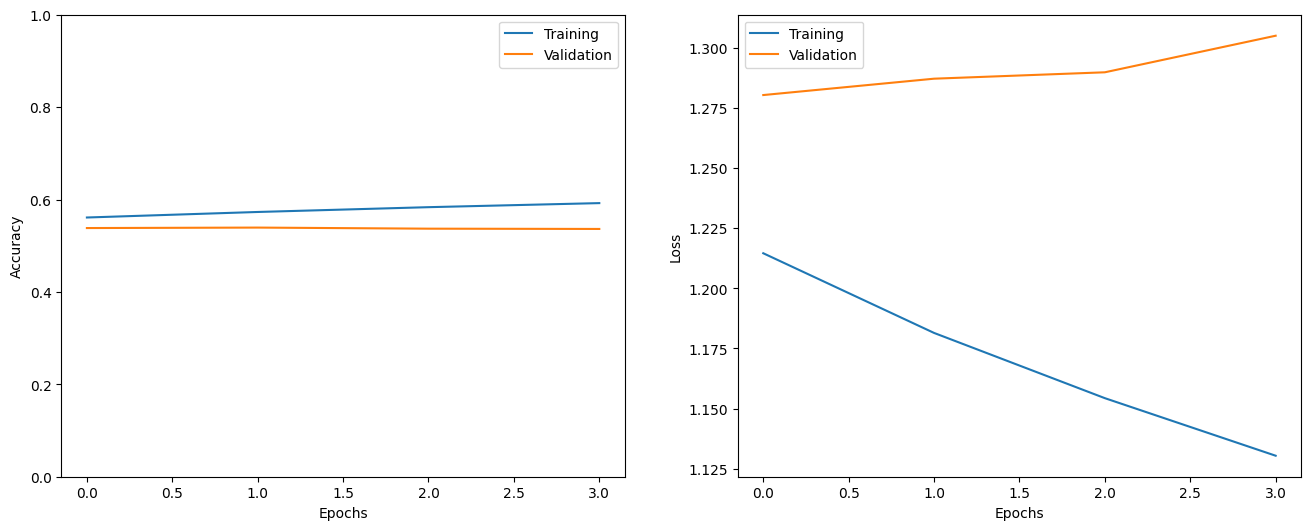

In [17]:
import matplotlib.pyplot as plt

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_val_encoded = model.predict(X_val_split)
y_pred_val_labels = np.argmax(y_pred_val_encoded, axis=1)

# 計算分類報告
print("Classification Report:")
print(classification_report(y_val_split, y_pred_val_labels, target_names=index_to_classes.values()))

# 計算混淆矩陣
print("Confusion Matrix:")
print(confusion_matrix(y_val_split, y_pred_val_labels))


4529/4529 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
Classification Report:
              precision    recall  f1-score   support

         joy       0.56      0.78      0.65     51416
    surprise       0.54      0.19      0.28      4745
        fear       0.60      0.36      0.45      6365
       trust       0.55      0.31      0.40     20505
     disgust       0.42      0.37      0.39     13937
       anger       0.39      0.26      0.31      3955
anticipation       0.63      0.52      0.57     24747
     sadness       0.44      0.47      0.45     19249

    accuracy                           0.54    144919
   macro avg       0.52      0.41      0.44    144919
weighted avg       0.54      0.54      0.52    144919

Confusion Matrix:
[[40100   186   450  2739  1475   276  3344  2846]
 [ 1799   899   102   160   553    65   279   888]
 [ 2248    44  2267   165   383    90   445   723]
 [ 9845    86   170  6438   739   107  1861  1259]
 [ 3607   148   205   370  5118   451   625  3413]
 [ 1065  

In [19]:
# 預測測試集
padded_test_sequences = get_sequences(tokenizer, test_df['clean_text'])
y_test_pred_encoded = model.predict(padded_test_sequences)
y_test_pred_labels = np.argmax(y_test_pred_encoded, axis=1)

# 添加預測結果到測試集
test_df['predicted_emotion'] = [index_to_classes[label] for label in y_test_pred_labels]

# 保存為 CSV
test_df[['tweet_id', 'predicted_emotion']].to_csv("submission_tf.csv", index=False)

print("Submission file saved as 'submission_tf.csv'.")

12875/12875 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step
Submission file saved as 'submission_tf.csv'.


In [13]:
# 模型定義
import xgboost as xgb
from torch import nn

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax', 
    num_class=len(label_encoder.classes_), 
    n_estimators=500,
    learning_rate=0.01,
    max_depth=5,
    random_state=42,
    tree_method='auto'
)
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))

# 模型定義：LSTM + Attention
# class LSTMWithAttention(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(LSTMWithAttention, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
#         self.attention = nn.Linear(hidden_dim * 2, 1)  # Linear layer for attention scores
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Final output layer

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_len, hidden_dim*2)
        
#         # Compute attention scores (shape: [batch_size, seq_len, 1])
#         attention_scores = torch.softmax(self.attention(lstm_out), dim=1)
        
#         # Apply attention weights to LSTM output
#         attended_output = torch.sum(attention_scores * lstm_out, dim=1)  # Summing over the sequence length

#         # Pass through the final fully connected layer
#         output = self.fc(attended_output)
#         return output
class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        # Ensure x is 3D: [batch_size, sequence_length, features]
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension if missing
        
        lstm_out, _ = self.lstm(x)
        
        # Compute attention scores
        attention_scores = self.attention(lstm_out).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        
        # Weighted sum of LSTM outputs
        attended_output = torch.sum(attention_weights.unsqueeze(-1) * lstm_out, dim=1)
        
        return self.fc(attended_output)



In [11]:
# 將特徵與標籤進行分割
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    train_features,  # 從 train_features 中劃分
    y_train, # 已編碼的目標值
    test_size=0.2,
    random_state=42,
    stratify=y_train  # 確保類別分佈一致
)

In [25]:
print(X_train_split.shape, y_train_split.shape)
print(X_val_split.shape, y_val_split.shape)

torch.Size([579672, 1372]) (579672,)
torch.Size([144919, 1372]) (144919,)


In [32]:
y_train_split_encoded = label_encoder.fit_transform(y_train_split)
y_train_split

array([4, 1, 7, ..., 7, 3, 7])

In [27]:
train_features_cpu = train_features.cpu().numpy()  # Move to CPU and convert to NumPy
y_train_cpu = y_train

# Check for NaN or infinity values in the features and labels
print(np.any(np.isnan(train_features_cpu)))  # Check for NaNs in the features
print(np.any(np.isnan(y_train_cpu)))         # Check for NaNs in the labels
print(np.any(np.isinf(train_features_cpu)))  # Check for infinities in the features
print(np.any(np.isinf(y_train_cpu)))         # Check for infinities in the labels

False
False
False
False


In [46]:
# 模型訓練與評估
# 1. XGBoost 模型
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_))
dtrain = xgb.DMatrix(train_features, label=y_train)
# xgb_model.fit(
#     X_train_split, y_train_split,
#     eval_set=[(X_val_split, y_val_split)],  # 驗證集評估
#     verbose=True
# )
#xgb_model.fit(X_train_split, y_train_split)
#y_pred_val_encoded = xgb_model.predict(X_val_split)

from sklearn.metrics import classification_report, confusion_matrix

# 將數值標籤轉回文字標籤
y_pred_val = label_encoder.inverse_transform(y_pred_val_encoded)
y_val_split_text = label_encoder.inverse_transform(y_val_split)

# 評估模型
print(confusion_matrix(y_val_split_text, y_pred_val))
print(classification_report(y_val_split_text, y_pred_val))

TypeError: fit() missing 1 required positional argument: 'y'

In [20]:
# 2. LSTM+Attention 模型
# 構建 DataLoader
batch_size = 16
accumulation_steps = 2
num_epochs = 5

# Create dataset and loader
train_dataset = TensorDataset(
    torch.tensor(X_train_split, dtype=torch.float32), 
    torch.tensor(y_train_split, dtype=torch.long)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
lstm_attention_model = LSTMWithAttention(
    input_dim=X_train_split.shape[1], 
    hidden_dim=64,  # Reduced hidden dimension 
    output_dim=len(label_encoder.classes_)
).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_attention_model.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    lstm_attention_model.train()
    epoch_loss = 0.0
    
    for i, (batch_features, batch_labels) in enumerate(train_loader):
        batch_features = batch_features.to('cuda')
        batch_labels = batch_labels.to('cuda')
        
        # Forward pass
        outputs = lstm_attention_model(batch_features)
        
        # Compute loss
        loss = criterion(outputs, batch_labels) / accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Update weights
        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {epoch_loss / len(train_loader)}")


C:\Users\t1070\AppData\Local\Temp\ipykernel_19048\3022464967.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_train_split, dtype=torch.float32),


Epoch 1/5, Average Loss: 0.7421766256730004
Epoch 2/5, Average Loss: 0.7017438596547917
Epoch 3/5, Average Loss: 0.6837248608342462
Epoch 4/5, Average Loss: 0.6710774905850075
Epoch 5/5, Average Loss: 0.6609893236499513


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
# Move test features to CUDA and ensure correct tensor type
# val_features_tensor = torch.tensor(X_val_split, dtype=torch.float32).to('cuda')

# # Evaluate LSTM model
# lstm_attention_model.eval()
# with torch.no_grad():
#     lstm_preds = torch.argmax(lstm_attention_model(val_features_tensor), dim=1).cpu().numpy()

# print("LSTM Confusion Matrix:")
# print(confusion_matrix(y_val_split, lstm_preds))
# print("\nLSTM Classification Report:")
# print(classification_report(y_val_split, lstm_preds))

# Validation loop
val_dataset = TensorDataset(
    torch.tensor(X_val_split, dtype=torch.float32), 
    torch.tensor(y_val_split, dtype=torch.long)
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

lstm_attention_model.eval()
val_preds = []
val_true = []
with torch.no_grad():
    for batch_features, batch_labels in val_loader:
        batch_features = batch_features.to('cuda')
        outputs = lstm_attention_model(batch_features)
        batch_preds = torch.argmax(outputs, dim=1).cpu().numpy()
        val_preds.extend(batch_preds)
        val_true.extend(batch_labels.numpy())

print("LSTM Confusion Matrix:")
print(confusion_matrix(val_true, val_preds))
print("\nLSTM Classification Report:")
print(classification_report(val_true, val_preds))

C:\Users\t1070\AppData\Local\Temp\ipykernel_19048\3508474324.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(X_val_split, dtype=torch.float32),


LSTM Confusion Matrix:
[[  92   61  100   10  251  265    2   23]
 [   3 2285   94   31 1837  369    7  285]
 [  28  146  703   31  863  908    7   85]
 [   1   94   51  273  585  221    3   42]
 [   5  659  170   55 8010  769   12  618]
 [  23  178  351   49 1299 1858    3   94]
 [   4   66   70   15  419  245  102   32]
 [   5  397  103   24 2214  334    3 1042]]

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.11      0.19       804
           1       0.59      0.47      0.52      4911
           2       0.43      0.25      0.32      2771
           3       0.56      0.21      0.31      1270
           4       0.52      0.78      0.62     10298
           5       0.37      0.48      0.42      3855
           6       0.73      0.11      0.19       953
           7       0.47      0.25      0.33      4122

    accuracy                           0.50     28984
   macro avg       0.53      0.33      0.36     28984
weighte

In [ ]:
# 3. Ensemble Voting
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lstm', lstm_attention_model)  # 注意：需調整框架以支持 VotingClassifier
], voting='hard')

voting_preds = [np.argmax(np.bincount([x, y])) for x, y in zip(xgb_preds, lstm_preds)]

print("Voting Classifier Confusion Matrix:")
print(confusion_matrix(y_test, voting_preds))
print("\nVoting Classifier Classification Report:")
print(classification_report(y_test, voting_preds))

In [ ]:
test_data['emotion'] = label_encoder.inverse_transform(voting_preds)
submission = test_data[['tweet_id', 'emotion']]
submission.to_csv('submission.csv', index=False)
print("Submission file created: 'submission.csv'")

In [23]:
test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to('cuda')

# Predict on test set
lstm_attention_model.eval()
with torch.no_grad():
    y_test_pred = torch.argmax(lstm_attention_model(test_features_tensor), dim=1).cpu().numpy()

# Inverse transform predictions
test_df['emotion'] = label_encoder.inverse_transform(y_test_pred)

# Output submission
submission = test_df[['tweet_id', 'emotion']]
submission.to_csv('lstm_submission.csv', index=False)

C:\Users\t1070\AppData\Local\Temp\ipykernel_19048\3397346809.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_features_tensor = torch.tensor(test_features, dtype=torch.float32).to('cuda')


In [ ]:
y_train = label_encoder.fit_transform(train_data['emotion'])
y_test = label_encoder.transform(test_data['emotion'])

X_train = np.array(train_data['bert_embeddings'].tolist())
X_test = np.array(test_data['bert_embeddings'].tolist())

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 訓練模型
input_dim = X_train.shape[1]
hidden_dim = 128
output_dim = len(label_encoder.classes_)

model = LSTMWithAttention(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 5
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('lstm', lstm_attention_model)
], voting='hard')

# 注意：LSTM + Attention 的訓練需要使用 DataLoader 和之前的訓練程式碼。
# Voting 會將 XGBoost 和 LSTM 的預測結合
voting_clf.fit(train_features, y_train)
final_predictions = voting_clf.predict(test_features)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# 將數值標籤轉回文字標籤
y_pred_val = label_encoder.inverse_transform(y_pred_val_encoded)
y_val_split_text = label_encoder.inverse_transform(y_val_split)

# 評估模型
print(confusion_matrix(y_val_split_text, y_pred_val))
print(classification_report(y_val_split_text, y_pred_val))


[[  460   196   638    37  1737   769     4    38]
 [   32 11747   880   137 10413  1243    14   486]
 [   70   635  4319   152  5325  3074     9   120]
 [    6   455   431  1623  3175   653     7    56]
 [   32  3258  1455   305 42798  2354    28  1251]
 [   82   979  2585   204  8177  6952    17   198]
 [    8   235   599    53  2447   781   614    72]
 [   12  1950   811    78 12834  1042    14  3753]]
              precision    recall  f1-score   support

       anger       0.66      0.12      0.20      3879
anticipation       0.60      0.47      0.53     24952
     disgust       0.37      0.32      0.34     13704
        fear       0.63      0.25      0.36      6406
         joy       0.49      0.83      0.62     51481
     sadness       0.41      0.36      0.39     19194
    surprise       0.87      0.13      0.22      4809
       trust       0.63      0.18      0.28     20494

    accuracy                           0.50    144919
   macro avg       0.58      0.33      0.37    14

In [10]:
# 預測測試集
y_test_pred_encoded = xgb_model.predict(X_test)
test_df['emotion'] = label_encoder.inverse_transform(y_test_pred_encoded)

# 輸出為 submission.csv
submission = test_df[['tweet_id', 'emotion']]
submission.to_csv('submission_final.csv', index=False)